#### Code Outline:

This code is for contour extraction from pots with amphora-like handles, i.e. handles that have been stuck on, that stick back on to the pot, that are positioned at the top of the pot (as opposed to the side, like usual). These include pots such as askos and amphora bails.

Like in cont_extraction_3 (aimed solely at pots with two amphora-like handles on each side), we will binarize the pot image, to avoid grabbing contours from patterns within the pot and so on. Then we will find the longest contour around the pot, and the largest contour near the top, which we hope would be the handle contour.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pylab as pl
import pandas as pd
from math import sqrt
from skimage.filters import threshold_otsu
from skimage import measure
import os
import re
import itertools as it
import csv
from PIL import Image
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
from copy import deepcopy

pl.ion()

### Functions

In [2]:
def find_centre(x,y):
    yc = min(y)+(max(y)-min(y))/2
    tnth = max(y)-(max(y)-min(y))/10
    coords = np.where((np.array(y)<tnth) & (np.array(y)>yc)) [0]
    xc = min(np.array(x)[coords])+(max(np.array(x)[coords])-min(np.array(x)[coords]))/2
    return xc,yc,coords

In [3]:
def get_contour_side(X,Y,D):
    
    xc,yc,coords = find_centre(X,Y)    
    
    tnth = min(X) + (max(X)-min(X))/10
    lb = xc - tnth
    ub = xc + tnth
    rng = []
    
    rng = np.where((X >= lb) & (X <=ub))[0]
    
    ktop = np.argmax(Y[rng])
    top_pnt = rng[ktop]
    
    kbot = np.argmin(Y[rng])
    bot_pnt = rng[kbot]

    mx_pnt = max(top_pnt,bot_pnt)
    mn_pnt = min(top_pnt,bot_pnt)
        
    xs1 = list(X[mn_pnt:mx_pnt])
    ys1 = list(Y[mn_pnt:mx_pnt])

    xs2 = list(X)[mx_pnt:] + list(X)[:mn_pnt] 
    ys2 = list(Y)[mx_pnt:] + list(Y)[:mn_pnt] 
    
    if D == "R":
        xs = xs2
        ys = ys2
    else:
        if D == "L":
            xs = xs1
            ys = ys1
        else:
            if min(xs1) > min(xs2):
                D1 = "R"
                D2 = "L"
            else:
                D1 = "L"
                D2 = "R"

            if len(ys1) >= len(ys2):
                ys = ys2
                xs = xs2
                D = D2
            else:
                ys = ys1
                xs = xs1
                D = D1


    return xs,ys,xc,yc,D

In [4]:
def get_handle_bot(x_,y_,bot):


    p1 = np.argmin(np.array(x_)[bot])
    p2 = np.argmax(np.array(x_)[bot])
    p1 = bot[p1]
    p2 = bot[p2]
    

    # Determine direction of contour (clockwise or anticlockwise).
    direc = "cw"
    mid = int(min(p1,p2) + (abs(p1-p2)/2))
    if (mid in bot) & (p1 < p2):
        direc = "acw"
        
    
    xh = []
    yh = []
    
    
    if p1 < p2:
        if direc == "cw":
            xh.extend(x_[p2:-1])
            yh.extend(y_[p2:-1])
            xh.extend(x_[0:p1])
            yh.extend(y_[0:p1])
        else:
            xh.extend(x_[p1:p2])
            yh.extend(y_[p1:p2])
    else:
        if direc == "cw":
            xh.extend(x_[p2:p1])
            yh.extend(y_[p2:p1])
        else:
            xh.extend(x_[p1:end])
            yh.extend(y_[p1:end])
            xh.extend(x_[0:p2])
            yh.extend(y_[0:p2])
    
    return xh,yh

In [5]:
def edit_pot_ends(x,y,xs,ys,side):
    
    xc,yc,coords = find_centre(x,y)
    
    if side == "unknown":
        if min(np.array(x)[coords]) < xc:
            side = "L"
        else:
            side = "R"
    
    if side == "L":
        coords2 = np.where(np.array(xs)<xc)[0]
    else:
        coords2 = np.where(np.array(xs)>xc)[0]
        
    xnew = []
    ynew = []
    xnew.append(xc)
    ynew.append(ys[0])
    xnew.extend(np.array(xs)[coords2])
    ynew.extend(np.array(ys)[coords2])
    xnew.append(xc)
    ynew.append(ys[-1])
   
    
    if side == "L":
        xnew = [(-1*i)+2*xc for i in xnew]

    return xnew,ynew

In [6]:
def smooth_side_contour(x,y,direction):
    
    y_ = deepcopy(np.round(y))
    x_ = deepcopy(np.round(x))
    
    ys = sorted(y_)
    ys = np.unique(ys)
        
    xs = []
    for i in range(0,len(ys)):
        inds = np.where(y_==ys[i])
        xy = x_[inds]
        if direction == 'R':
            xs.append(max(xy))
        else:
            xs.append(min(xy))
            
    return xs,ys

In [7]:
def get_longest_contours(img):
    
    thresh = threshold_otsu(img)
    binary = img > thresh
    cont = measure.find_contours(binary, 0.8)

    # Find longest contour:
    cont_ln = []
    for n, contour in enumerate(cont):
        cont_ln.append(len(contour))

    longest_c = sorted(cont_ln,reverse=True)[:10]
    long_ind = []
    long_ind_rngsx = []
    long_ind_rngsy = []
    long_ind_mx = []
    long_ind_mn = []


    for i in range(0,len(cont_ln)):
        if cont_ln[i] in longest_c:
            long_ind.append(i)
            c = cont[i]
            x = c[:,1]
            y = c[:,0]
            rngy = abs(max(y) - min(y))
            rngx = abs(max(x) - min(x))
            long_ind_rngsy.append(rngy)
            long_ind_rngsx.append(rngx)
            long_ind_mx.append(max(y))
            long_ind_mn.append(min(y))

    n = len(long_ind)
    
    mn = min(long_ind_mn)
    
    mx = max(long_ind_rngsy)
        
    k1 = np.argmax(long_ind_rngsy)
    
    ub = long_ind_mn[k1] + (long_ind_rngsy[k1]/3)
    
    inds = []
    for i in range(0,n):
        if (long_ind_mn[i] < ub) & (i != k1):
            inds.append(i)
    
    k2 = np.argmax(np.array([long_ind_rngsy[i]+long_ind_rngsx[i] for i in range(len(long_ind_rngsy))])[inds])
    k2 = inds[k2]

    
    k1 = long_ind[k1]
    k2 = long_ind[k2]


    c1 = cont[k1]
    x1 = c1[:,1]
    y1 = c1[:,0]

    c2 = cont[k2]
    x2 = c2[:,1]
    y2 = c2[:,0]

    
    return x1,y1,x2,y2



In [8]:
def get_bot_area_handle(x_,y_):

    ubt = np.max(y_)
    mn = np.min(y_)
    ubb = ubt - ((ubt - mn)/10) 

    bot = []

    for i in range(0,len(x_)):
        if ubb <= y_[i] <= ubt:
            bot.append(i)
            
    return bot

In [9]:
def binary_colour(img):
    x_len = len(img[0])
    y_len = len(img)
    img2 = deepcopy(img)
    k = 1
    
    t1 = 190 #black
    t2 = 215 #white
    
    if np.mean(img) < 110:
        t1 = 121
        t2 = 120
    
    if isinstance(img[1][2], np.uint8) == True:
        k = 0;

    if k == 1:
        for i in range(0,y_len):
            for j in range(0,x_len):
                if (img[i][j][0] < t1) and (img[i][j][1] < t1) and (img[i][j][2] < t1): 
                    img2[i][j] = [0,0,0]

                if (img[i][j][0] > t2) and (img[i][j][1] > t2) and (img[i][j][2] > t2): 
                    img2[i][j] = [255,255,255]
    else:
        for i in range(0,y_len):
            for j in range(0,x_len):
                if (img[i][j] < t1):
                    img2[i][j] = 0

                if (img[i][j] > t2):
                    img2[i][j] = 255
    
    for i in range(1,y_len-1):
        for j in range(1,x_len-1):
            if ((np.sum(img2[i+1][j+1]) == 0) & (np.sum(img2[i-1][j-1]) == 0)) or ((np.sum(img2[i+1][j]) == 0) & (np.sum(img2[i-1][j]) == 0)) or ((np.sum(img2[i][j+1]) == 0) & (np.sum(img2[i][j-1]) == 0)) or ((np.sum(img2[i+1][j-1]) == 0) & (np.sum(img2[i-1][j+1]) == 0)):
                if k == 1:
                    img2[i][j] = [0,0,0]
                else:
                    img2[i][j] = 0

    by = len(img2)
    bx = len(img2[1])
    by = int(np.ceil(by*0.01))
    bx = int(np.ceil(bx*0.01))

    for i in range(by,y_len-by):
        for j in range(bx,x_len-bx):
            if ((np.sum(img2[i+by][j]) == 0) & (np.sum(img2[i-by][j]) == 0)) or ((np.sum(img2[i][j+bx]) == 0) & (np.sum(img2[i][j-bx]) == 0)):
                if k == 1:
                    img2[i][j] = [0,0,0]
                else:
                    img2[i][j] = 0

    return img2

In [10]:
def cont_extraction_5(img_path,cur_dir):
    
    try:
        # 2.1) Get B/W version of original image.
        image_col = data.load(img_path,as_gray=False)
        image_bw = binary_colour(image_col)
        # 2.2) Create a plot and temporarily save. This will be the new B/W of the pot.
        fig, ax = plt.subplots(figsize=(4, 6))
        ax.imshow(image_bw)
        ax.set_axis_off()
        plt.savefig("pot_new.jpg")
        plt.close()        
        # 2.3) Get longest contour from new pot image.
        image_grey = data.load(cur_dir+'\\pot_new.jpg',as_gray=True)        

    except:
        # 1) Find longest contour from oringal pot image. We assume/hope this is the outline of the pot.
        image_grey = data.load(img_path,as_gray=True)

    x1,y1,x2,y2 = get_longest_contours(image_grey)
    

    # 3) Get one side of contour. 
    # "L" in the third parameter gets the left side of the pot, "R" the right side, and anything else gets
    # the shortest side.
    xs,ys,xc,yc,D = get_contour_side(x1,y1,"Z")
    
    # 4) Smooth the contour
    xsmooth,ysmooth = smooth_side_contour(xs,ys,D)
    
    bot = get_bot_area_handle(x2,y2)
    
    xh,yh = get_handle_bot(x2,y2,bot)
    
    mx = max(yh)
    
    ub = mx + (mx-min(y2))/7
    
    k2 = np.where(ysmooth > ub)[0][0]
    
    if D == "L":
        if xh[0] < xh[-1]:
            xh.reverse()
            yh.reverse()
    
    if D == "R":
        if xh[0] > xh[-1]:
            xh.reverse()
            yh.reverse()
            
    if ysmooth[0] > ysmooth[-1]:
        ysmooth.reverse()
        xsmooth.reverse()
        
    t = []
    if D == "L":
        for i in range(0,len(xh)-1):
            if (yh[i] < yh[i+1]) & (xh[i] > xh[i+1]):
                t.append(i)
    else:
        for i in range(0,len(xh)-1):
            if (yh[i] < yh[i+1]) & (xh[i] < xh[i+1]):
                t.append(i)
    
    k1 = len(xh)-1
    if len(t) != 0:            
        k1 = t[-1]
    
    xr = []
    yr = []
    
    xr.extend(xh[:k1])
    yr.extend(yh[:k1])        
    xr.extend(xsmooth[k2:])
    yr.extend(ysmooth[k2:])
    
    xsr,ysr = smooth_side_contour(xr,yr,D)            
    x,y = edit_pot_ends(x1,y1,xsr,ysr,D)
    
    
    return image_grey,x,y
    

### Test

In [14]:
direc_nme = "C:\\Users\\arian\\Documents\\a3"
current_direc = "C:\\Users\\arian\\Documents\\GitHub\\pots\\Code"
img,x,y = cont_extraction_5(direc_nme+"\\askos_NA_athenian_red-figure_449.jpg",current_direc)


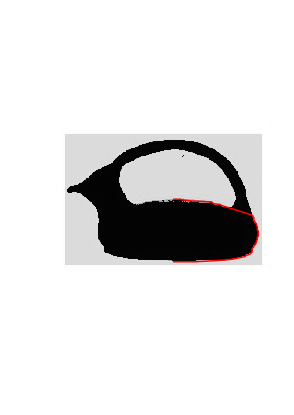

In [15]:
fig, ax = plt.subplots(figsize=(5, 7))
ax.imshow(img,cmap='gray')
ax.plot(x,y,'-r')
ax.set_axis_off()
#plt.savefig("askos.png")